The first step–before we start to build a model–is always to take a closer look at the data by analyzing
some statistics of the data set. In this step, you can already gain some insights into the data which can
help you build your model and interpret your results later on.
Look into the provided data set by e.g. plotting the individual features. Based on your analysis,
answer the following questions:
(i) Which are the numerical features and which are the categorical features?
(ii) Is there a greater trend to need an increase in the availability of bicycles? Study this question
from various perspectives:
• Can any trend be seen comparing different hours, weeks, and months?
• Is there any difference between weekdays and holidays?
• Is there any trend depending on the weather? Rainy days, snowy days, etc.
Write concise answers to each question and support your findings with evidence (statistics, plots,
etc.). Discuss the results. Additionally, you can explore the correlation of features, outliers, range of
values, and many more aspects

Data shape: (1600, 16)
Columns: ['hour_of_day', 'day_of_week', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'increase_stock']
   hour_of_day  day_of_week  month  holiday  weekday  summertime  temp   dew  \
0            5            5      1        0        0           0  -7.2 -15.0   
1           21            4      1        0        1           0  -1.3 -12.8   
2           21            3      8        0        1           1  26.9  21.8   
3            1            6      1        0        0           0   3.1  -4.0   
4           17            0      3        0        1           0  11.7 -11.4   

   humidity  precip  snow  snowdepth  windspeed  cloudcover  visibility  \
0     53.68     0.0     0        0.0       16.3        31.6        16.0   
1     40.97     0.0     0        0.0       23.9        85.7        16.0   
2     73.39     0.0     0        0.0        0.0        81.1        16

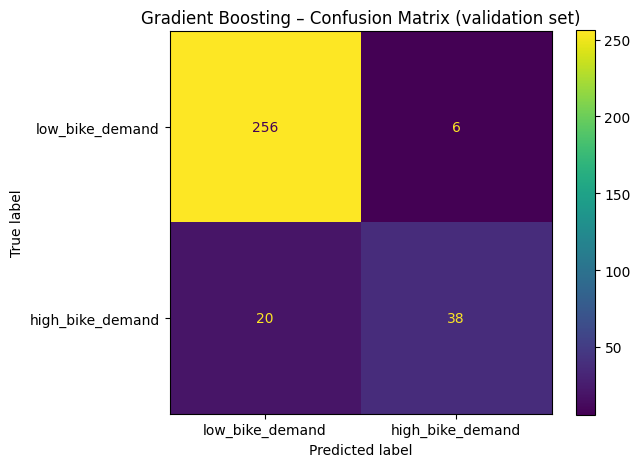

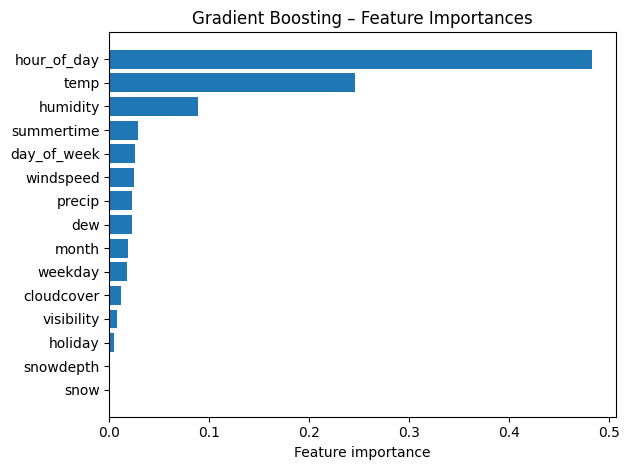

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)

RANDOM_STATE = 42


def main():
    # Load data
    df = pd.read_csv("training_data_ht2025.csv")

    # Quick check
    print("Data shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print(df.head())

    # Encode label: low_bike_demand -> 0, high_bike_demand -> 1
    df["target"] = df["increase_stock"].map(
        {"low_bike_demand": 0, "high_bike_demand": 1}
    )

    # Features: all columns except label and target
    X = df.drop(columns=["increase_stock", "target"])
    y = df["target"]

    # Train/validation split (keep class balance with stratify)
    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y,
    )

    print("\nTrain size:", X_train.shape[0], "Validation size:", X_val.shape[0])

    # Naive baseline
    #    Always predict the majority class in the training set
    majority_class = y_train.value_counts().idxmax()
    y_val_naive = np.full_like(y_val, fill_value=majority_class)
    naive_acc = accuracy_score(y_val, y_val_naive)

    print("\nNaive baseline:")
    print("  Majority class:", majority_class)
    print("  Validation accuracy (naive):", naive_acc)

    # 5. Define Gradient Boosting model
    base_gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

    # Hyperparameter grid for tuning
    param_grid = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [1, 2, 3],
    }

    # Grid search with cross-validation (tune for F1-score)
    grid = GridSearchCV(
        estimator=base_gb,
        param_grid=param_grid,
        cv=5,
        scoring="f1",
        n_jobs=-1,
        verbose=1,
    )

    print("\nFitting Gradient Boosting with GridSearchCV...")
    grid.fit(X_train, y_train)

    print("\nBest parameters found:")
    print(grid.best_params_)
    print("Best CV F1-score:", grid.best_score_)

    # Evaluate best model on validation set
    best_gb = grid.best_estimator_

    y_val_pred = best_gb.predict(X_val)

    print("\nValidation performance of tuned Gradient Boosting:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("\nClassification report:")
    print(classification_report(y_val, y_val_pred))

    #Confusion matrix plot (for the report)
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["low_bike_demand", "high_bike_demand"]
    )
    disp.plot()
    plt.title("Gradient Boosting – Confusion Matrix (validation set)")
    plt.tight_layout()
    plt.savefig("confusion_matrix_gb.png", dpi=300)
    # plt.show()  # uncomment if you want to see interactively

    #Feature importance plot (for the report)
    importances = best_gb.feature_importances_
    feature_names = X.columns

    # Sort by importance
    idx_sorted = np.argsort(importances)
    sorted_importances = importances[idx_sorted]
    sorted_names = feature_names[idx_sorted]

    plt.figure()
    plt.barh(sorted_names, sorted_importances)
    plt.xlabel("Feature importance")
    plt.title("Gradient Boosting – Feature Importances")
    plt.tight_layout()
    plt.savefig("feature_importances_gb.png", dpi=300)
    # plt.show()

    print("\nSaved plots:")
    print("  confusion_matrix_gb.png")
    print("  feature_importances_gb.png")


if __name__ == "__main__":
    main()
